# DATA 620 - Final Project

Jeremy OBrien, Mael Illien, Vanita Thompson

## Topic Networks

### Introduction

A powerful analytical application of NLP is topic modeling, which identifies the themes present in a corpus comprised of multiple documents based on the words in those documents. Because it can be used to uncover the thematic structure in documents, topic modeling has an array of applications in information retrieval and document mining.

Topics are 'probability distributions over a fixed vocabulary'. An overview of topic modeling and its current applications in bioinformatics, and it's common to use probabilistic generative models derived from LDA (Latent Dirichlet Allocation) to model in an unsupervised fashion the latent semantic structure of documents. Topic models can be tuned and optimized in a variety of ways, including improving how topics are segregated from each other and calibrating for a useful number of topics.

### Research Question
We will combine techniques from topic modeling and network analysis to address this question.

*Given a text corpus comprised of multiple documents, what are the topics of those documents and how are the documents thematically related to one another?*

### Approach
- Leverage the Reuters news corpus of nearly 11,000 articles (labeled with at least one category each; unfortunately, authorship is not labeled)
- Using the NLTK, Spacy, and Gensim packages, implement and tune an unsupervised LDA-based topic model (i.e. without reference to the provided article topic labels)
- Analyze model perplexity and coherence, overall topic prevalence, and topic distribution across articles
- Generate a bipartite, weighted (on likelyhood of belonging to the most domiant topic) graph of articles and topics, and analyze its topology to identify relationships between topics 

## Setup

In [1]:
import re
import random
import numpy as np
import pandas as pd
from pprint import pprint

np.random.seed(12321)

import nltk
from nltk.corpus import stopwords
from nltk.corpus import reuters

import spacy  # need to install

import gensim  # need to install
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
# warnings.filterwarnings('ignore', category=DeprecationWarning)

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Reuters corpus
from nltk.corpus import reuters

## Data Import & Processing

### Data import and preliminary EDA

Per the NLTK Reuters README (accessible via `reuters.readme()`), this corpus include 10,788 article from the Reuters financial newswire service.  While it is partitioned into training and test sets, we will not be making use of these splits for this project.

In [2]:
# Generate dataframe of Reuters
news = []
for fileid in reuters.fileids():
    tag, filename = fileid.split('/')
    news.append((filename, tag, reuters.categories(fileid), reuters.raw(fileid)))
df = pd.DataFrame(news, columns=['Article', 'Tag', 'Category', 'Text'])

# Optional view, otherwise just use df
df.head(5).style.hide_index().hide_columns(['Tag'])

In [3]:
# Function to calculate category makeup of corpus
def category_count(df):
    
    cats = list(reuters.categories())
    cat_count = []
    
    # Count an article with multiple categories in tuple
    for cat in cats:
        cat_count.append(len(df[[cat in x for x in df['Category']]]))
    
    count_df = pd.DataFrame(cat_count, cats).reset_index()
    count_df.set_axis(['Category', 'Article Count'], axis=1, inplace=True)
    count_df.sort_values(by=['Article Count'], ascending=False, inplace=True)
    count_df.reset_index(drop=True, inplace=True)
    count_df['Percentage'] = count_df['Article Count'] / count_df['Article Count'].sum()
    
    return count_df

article_props = category_count(df)
display(article_props.head(n=10))
display(article_props.tail(n=10))
print('Categories with less than 1% of all articles: ', len(article_props[article_props['Percentage'] < .01]))
print('Categories with less than .1% of all articles: ', len(article_props[article_props['Percentage'] < .001]))

,Category,Article Count,Percentage
0,earn,3964,0.297419
1,acq,2369,0.177746
2,money-fx,717,0.053797
3,grain,582,0.043667
4,crude,578,0.043367
5,trade,485,0.036390
6,interest,478,0.035864
7,ship,286,0.021459
8,wheat,283,0.021233
9,corn,237,0.017782


,Category,Article Count,Percentage
80,palladium,3,0.000225
81,palmkernel,3,0.000225
82,copra-cake,3,0.000225
83,dfl,3,0.000225
84,cotton-oil,3,0.000225
85,sun-meal,2,0.000150
86,groundnut-oil,2,0.000150
87,rye,2,0.000150
88,lin-oil,2,0.000150
89,castor-oil,2,0.000150


Categories with less than 1% of all articles:  74
Categories with less than .1% of all articles:  28


The corpus is labeled with 90 different categories. Each article can be labelled with multiple categories (e.g. 'trade' and 'ship').

There is considerable category skew and a pronounced long tail: 'earn' (29.7%) and 'acq' (17.7%) represent nearly half the articles in the corpus, while 74 categories have less than 1% of all articles, and 28 have less than .1%. 

However, given LDA is unsupervised and these labels aren't used, category skew does not impact the performance of topic modeling.

### Text preparation and tokenization

LDA aims to describe document collections by assigning topics based on the those documents' word frequency.  To do this the words must be demarcated and standardized for lexical analysis.

We remove characters, diacritics, and punctuation, and convert all text to lower case tokens.

In [4]:
# Convert text to list
data = df['Text'].values.tolist()

# Remove new line characters and single quotes
data = [re.sub(r'\s+', ' ', sent) for sent in data]
data = [re.sub(r"\'", "", sent) for sent in data]

# Function to tokenize words and remove punctuation
def sentence_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuation

data_words = list(sentence_to_words(data))

# Impact of text preparation
print('\nOriginal text: \n', (df.iloc[330,3][:300]))
print('\nAfter cleaning: \n', data[330][:300])
print('\nAfter tokenization: \n', data_words[330][:30])


Original text: 
 G-7 ISSUES STATEMENT AFTER MEETING
  Following is the text of a statement
  by the Group of Seven -- the U.S., Japan, West Germany, France,
  Britain, Italy and Canada -- issued after a Washington meeting
  yesterday.
      1. The finance ministers and central bank governors of
  seven major industr

After cleaning: 
 G-7 ISSUES STATEMENT AFTER MEETING Following is the text of a statement by the Group of Seven -- the U.S., Japan, West Germany, France, Britain, Italy and Canada -- issued after a Washington meeting yesterday. 1. The finance ministers and central bank governors of seven major industrial countries me

After tokenization: 
 ['issues', 'statement', 'after', 'meeting', 'following', 'is', 'the', 'text', 'of', 'statement', 'by', 'the', 'group', 'of', 'seven', 'the', 'japan', 'west', 'germany', 'france', 'britain', 'italy', 'and', 'canada', 'issued', 'after', 'washington', 'meeting', 'yesterday', 'the']


### Pre-processing and feature engineering

Stopwords are abundant in English. Their high frequency provides very little information to inform topic modeling, so we remove them from the tokens.

In [5]:
# Function to remove stopwords
def remove_stopwords(texts):
    
    # Identify stopwords using NLTK and amend
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
    
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Remove stop words
data_words_nostops = remove_stopwords(data_words)

Some adjacenet words are known to convey different meaning.  We associate  these words in pairs called bigrams, and add them to the tokens.

In [ ]:
# Function to make bigrams
def make_bigrams(texts):
    
    # Generate bigram model
    bigram = gensim.models.Phrases(data_words, 
                                   min_count=5, # must occur at least five times in corpus to be counted
                                   threshold=100)  # higher threshold fewer phrases
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    return [bigram_mod[doc] for doc in texts]

# Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

Words are inflected when their use in speech changes due to 'tense, case, voice, aspect, person, number, gender, and mood' [Wikipedia](https://en.wikipedia.org/wiki/Inflection).  These inflections in nouns (declension) and verbs (conjugation) can take the form of prefixes, suffixes, or infixes.  **Stemming** uses an algorithmic approach that is more approximate than **lemmatization**, which uses dictionaries to identify root forms.

We lemmatize the tokens to normalize them for topic modeling.

In [7]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    # https://spacy.io/api/annotation
    
    texts_out = []
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

# MI: do we use the nlp variable below anywhere?

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Perform lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

print(data_lemmatized[0][:30])

['asian', 'exporter', 'fear', 'damage', 'mount', 'trade', 'friction', 'raise', 'fear', 'many', 'asia', 'export', 'nation', 'row', 'could', 'inflict', 'far', 'reach', 'economic', 'damage', 'businessman', 'official', 'say', 'tell', 'asian', 'capital', 'move', 'may', 'boost', 'protectionist_sentiment']


We create a dictionary representation of the tokens in the corpus, calculating the term document frequency for each token.  With this, we can proceed with topic modeling.

In [8]:
# Create dictionary representation of corpus
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus with term document frequency
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 4), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


## Topic Modeling Training

### Preliminary Topic Model

We generate a topic model for the article.  We employ two approaches:

1. Gensim's built-in LDA topic modeling function, `ldamodel`.  Gensim implementations of LDA employ Variational Inference, which introduces bias and can provide less coherence in topics.
2. MALLET's LDA topic model with a Gensim wrapper, `ldamallet`.  This model employs Gibbs sampling (an MCMC method), which is unbiased at the cost of heavy computation (performed in Java).

LDA models can be evaluated based on several different metrics:

- **Perplexity** is a [measure](https://en.wikipedia.org/wiki/Perplexity) of 'surprise', or how well the model predicts.  The lower the score, the better the prediction.
- **Coherence** is the degree of 'semantic similarity between high scoring keywords in the topic' [Learn to Find Topics in a Text Corpus](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0).  It is computed as a the sum of pairwise scores of the top n words by frequency.  The higher the coherence, the more coherent and interpretable the topic. 

Selecting the number of topics in an LDA model can be an arbitrary decision. We inform this decision through hyperparameter tuning based on an evaluation of the topic coherence yielded by different numbers of topics.  

We optimize the Gensim model accordingly (JO: MALLET too?)

In [10]:
# Function to generate Gensim LDA model
def gensim_ldamodel(corpus, num_topics):
    
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,  # TDF corpus
                                               id2word=id2word,  # dictionary
                                               num_topics=num_topics,  # to be optimized
                                               random_state=100,  # [JO: CONFIRM]
                                               # update_every=1,  # how often paramater should be updated
                                               # chunksize=100,
                                               # passes=10,  # total number of training passes
                                               # alpha='auto',  # learn assymetric alpha from training data (JO: consider whether to evaluate symmetric approach for alpha with asymmetric for beta)
                                               per_word_topics=True)
    
    return model

# Function to generate MALLET LDA model
def mallet_ldamodel(corpus, num_topics):
    
    mallet_path = './mallet-2.0.8/bin/mallet' 
    
    model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                        corpus=corpus, 
                                        num_topics=num_topics, 
                                        id2word=id2word)
    
    return model

# Function to iterate over numbers of topics and calculates LDA model coherence
def compute_coherence_values(model_type, dictionary, corpus, texts, limit, start=2, step=3):
   
    coherence_values = []
    model_list = []
    coherence='c_v'
    
    for num_topics in range(start, limit, step):
        
        if model_type == 'LdaModel':
            model = gensim_ldamodel(corpus=corpus,
                           num_topics=num_topics)
            
        elif model_type == 'LdaMallet':
            model = mallet_ldamodel(corpus=corpus,
                                    num_topics=num_topics)
            
        else:
            print('model_type not supported')
            break
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts,
                                        dictionary=id2word, 
                                        coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values  # List of LDA topic models and coherence values for respective number of topics

# Function to support decision on optimal number of topics
def chart_model_coherence(coherence_values, limit, start=2, step=3):
    
    x = range(start, limit, step)
    
    coherence_table = pd.DataFrame(list(zip(x,coherence_values)), columns=['Num Topics','Coherence Score'])
    
    plt.plot(x, coherence_values)
    plt.xlabel('Num Topics')
    plt.ylabel('Coherence Score')
    plt.legend(('coherence_values'), loc='best')
    plt.show()
    
    return coherence_table

### Gensim LDA model

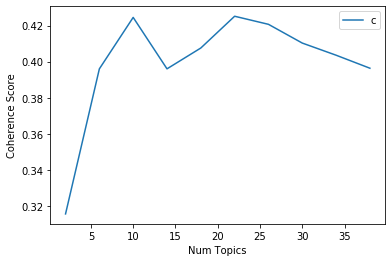

,Num Topics,Coherence Score
0,2,0.315559
1,6,0.396004
2,10,0.424539
3,14,0.396019
4,18,0.407569
5,22,0.425183
6,26,0.420701
7,30,0.410306
8,34,0.403574
9,38,0.396359


In [11]:
# Cast broad net to find neighborhood of optimal number of topics in range of 2 to 40 in steps of 4
gs_broad_model_list, gs_broad_coherence_values = compute_coherence_values(model_type='LdaModel',
                                                                          dictionary=id2word, 
                                                                          corpus=corpus, 
                                                                          texts=data_lemmatized, 
                                                                          start=2, 
                                                                          limit=40, 
                                                                          step=4)

# Chart broad net of optimal number of topics
chart_model_coherence(gs_broad_coherence_values, 
                      start=2, 
                      limit=40, 
                      step=4)

When analyzed at 4 topic steps, Gensim LDA model coherence peaks between 6 and 25 topics.  It's not very smooth, so given that the spikes could be obscuring the optimum we narrow our search in that range with 1 topic steps.

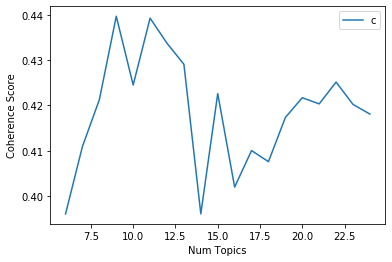

,Num Topics,Coherence Score
0,6,0.396004
1,7,0.410933
2,8,0.421290
3,9,0.439753
4,10,0.424539
5,11,0.439331
6,12,0.433781
7,13,0.429110
8,14,0.396019
9,15,0.422628


In [13]:
# Cast narrower net in range of 6 to 25 in single steps to smooth and find optimum in number of topics
gs_narrow_model_list, gs_narrow_coherence_values = compute_coherence_values(model_type='LdaModel',
                                                                            dictionary=id2word, 
                                                                            corpus=corpus, 
                                                                            texts=data_lemmatized, 
                                                                            start=6, 
                                                                            limit=25, 
                                                                            step=1)

# Chart narrower net of optimal number of topics
gs_narrow_coherence = chart_model_coherence(gs_narrow_coherence_values, 
                      start=6, 
                      limit=25, 
                      step=1)     
gs_narrow_coherence

9 topics yield the highest coherence score so we select the model with a k of 9. Here is a snapshot of top words for each of the 9 topics in this model.

In [19]:
# Optimal Gensim model
# gs_optimal_model = gs_narrow_model_list[int(gs_narrow_coherence.loc[gs_narrow_coherence['Coherence Score'].idxmax()]['Num Topics'])]
gs_optimal_model = gensim_ldamodel(corpus=corpus, num_topics=9)

# Compute model perplexity and coherence score
print('\nGensim LDA model perplexity: ', gs_optimal_model.log_perplexity(corpus))

# print('\nGensim LDA model coherence score: ', gs_narrow_coherence.loc[gs_narrow_coherence['Coherence Score'].idxmax()]['Coherence Score'])
print('\nGensim LDA model coherence score: ', CoherenceModel(model=gs_optimal_model, texts=texts).get_coherence(), '\n')

# Here is a quick look at the the top words by topic for the optimal Gensim model
for topic_id in range(gs_optimal_model.num_topics):
    top_k = gs_optimal_model.show_topic(topic_id, 10)
    top_k_words = [w for w, _ in top_k]
    
    print('{}: {}'.format(topic_id, ' '.join(top_k_words)))


Gensim LDA model perplexity:  -7.09569318797269

Gensim LDA model coherence score:  0.43975307826479676 

0: say year rate rise quarter expect growth first earning increase
1: price say oil raise crude trader barrel today dlrs rate
2: say crop year deficit soybean estimate last trade surplus program
3: say company share offer would buy stock group also sell
4: say bank market rise dollar rate dealer money yen currency
5: loss net ct profit dlrs sale year say include note
6: say trade would export official government import country year japanese
7: share ct say dividend stock record split dlrs may pay
8: say year oil price production last would rise market export


### MALLET LDA model

JO: Mael, what if we trained both models first in this section, and then compared their relative performance before selecting MALLET and analyzing its output?

In [ ]:
# Cast broad net to find neighborhood of optimal number of topics in range of 2 to 40 in steps of 4
mlt_broad_model_list, mlt_broad_coherence_values = compute_coherence_values(model_type='LdaMallet',
                                                                          dictionary=id2word, 
                                                                          corpus=corpus, 
                                                                          texts=data_lemmatized, 
                                                                          start=2, 
                                                                          limit=40, 
                                                                          step=4)

# Chart broad net of optimal number of topics
chart_model_coherence(mlt_broad_coherence_values, 
                      start=2, 
                      limit=40, 
                      step=4)

In [ ]:
# Cast narrower net in range of 6 to 25 in single steps to smooth and find optimum in number of topics
mlt_narrow_model_list, mlt_narrow_coherence_values = compute_coherence_values(model_type='LdaMallet',
                                                                            dictionary=id2word, 
                                                                            corpus=corpus, 
                                                                            texts=data_lemmatized, 
                                                                            start=6, 
                                                                            limit=25, 
                                                                            step=1)

# Chart narrower net of optimal number of topics
mlt_narrow_coherence = chart_model_coherence(mlt_narrow_coherence_values, 
                      start=8, 
                      limit=25, 
                      step=1)     
mlt_narrow_coherence

In [ ]:
# Optimal Gensim model
mlt_optimal_model = mlt_narrow_model_list[int(mlt_narrow_coherence.loc[mlt_narrow_coherence['Coherence Score'].idxmax()]['Num Topics'])]

# Compute model perplexity and coherence score
print('\nMallet LDA model perplexity: ', lda_model.log_perplexity(corpus))
print('\nMallet LDA model coherence score: ', mlt_narrow_coherence.loc[mlt_narrow_coherence['Coherence Score'].idxmax()]['Coherence Score'])

In [ ]:
# Here is a quick look at the the top words by topic for the optimal Gensim model
for topic_id in range(mlt_optimal_model.num_topics):
    top_k = optimal_model.show_topic(topic_id, 10)
    top_k_words = [w for w, _ in top_k]
    
    print('{}: {}'.format(topic_id, ' '.join(top_k_words)))

In [ ]:
# Build LDA Mallet model
# mallet_path = './mallet-2.0.8/bin/mallet' 
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# # Show topics
# pprint(ldamallet.show_topics(formatted=False))

In [ ]:
# Compute coherence score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
#                                             texts=data_lemmatized,
#                                             dictionary=id2word, 
#                                             coherence='c_v')

# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence score: ', coherence_ldamallet)

## Topic Model Analysis & Visualization

### {Best model} Topic Prevalence and Distribution 

For commentary: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [ ]:
# JO: assuming MALLET is the top performer, do this for MALLET only?

# MI: I think yes. Less to talk about. Avoid some repetition.

# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

### Most Dominant Topics

#### Best Gensim Topics

In [ ]:
# Extract best topic for each article along with associate keywords and likelyhood
def get_best_gensim_topics(lda_model, corpus):
    
    lda_model_corpus = lda_model[corpus]
    art_topic_keywords = pd.DataFrame(columns = ['article','best_topic','likelyhood','keywords'])
    
    # Loop through articles to get each article's main topic
    for i, article in enumerate(lda_model[corpus]):
        for article in enumerate(article): 
            if article[0] == 0:
                #print(article)
                wp = optimal_model.show_topic(article[1][0][0])
                topic_keywords = ', '.join([word for word, prop in wp])
                
                best_topic = int(article[1][0][0])
                max_likelyhood = round(article[1][0][1],4)
                
                d = {'article': i, 'best_topic': best_topic,'likelyhood': max_likelyhood,'keywords': topic_keywords}
                art_topic_keywords = art_topic_keywords.append(d, ignore_index=True)

    return art_topic_keywords

In [ ]:
lda_gensim_opt_model = optimal_model
gensim_topic_df = get_best_gensim_topics(lda_gensim_opt_model, corpus)

In [ ]:
gensim_topic_df

#### Best Mallet Topics

In [ ]:
# Extract best topic for each article along with associate keywords and likelyhood
def get_best_mallet_topics(lda_model, corpus):
    lda_model_corpus = lda_model[corpus]
    art_topic_keywords = pd.DataFrame(columns = ['article','best_topic','likelyhood','keywords'])
    
    for i in range(len(lda_model_corpus)):
        # Get article topic model distribution
        article = lda_model_corpus[i]

        # Find the max likelyhood index and select the corresponding topic
        likelyhood = [likelyhood for topic,likelyhood in article]
        max_likelyhood = max(likelyhood)
        best_topic = likelyhood.index(max_likelyhood)
        
        # Get keywords for best topcis
        wp = lda_model.show_topic(best_topic)
        topic_keywords = ', '.join([word for word, prop in wp])
        
        # Assemble and append information to dataframe
        d = {'article': i, 'best_topic': best_topic,'likelyhood': max_likelyhood,'keywords': topic_keywords}
        art_topic_keywords = art_topic_keywords.append(d, ignore_index=True)
        
    return art_topic_keywords
    

In [ ]:
mallet_topic_df = get_best_mallet_topics(ldamallet, corpus)

In [ ]:
mallet_topic_df

## Topic Comparison

Discuss overlap between columns. Maybe read an example article to validate. Talk about verification.

In [ ]:
# Create summary dataframe with keywords from each model vs known categories
summary_df = pd.concat([df['categories'], gensim_topic_df['keywords'], mallet_topic_df['keywords']], axis=1, sort=False)
summary_df.columns = ['reuters_categories','gensim_keywords','mallet_keywords']

In [ ]:
summary_df

In [ ]:
# Show example 

In [ ]:
# Print chosen dataframe to csv file
mallet_topic_df.to_csv('mallet_df.csv', index=False) 

## Network Analysis

- Expecting a disconnected graph with num_topics central nodes with edges to articles. 
- Get the top 5 largest subgraphs which represent the most common topics (degree centrality)
- From the most popular topics, suggest next 5 articles to read by looking at edge weight (likelyhood).

In [ ]:
# Read dataframe from csv file and build a graph from it.

In [ ]:
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [ ]:
G_full = nx.from_pandas_edgelist(art_topic_keywords,'article','best_topic')
G_full.graph['name'] = 'Full bipartite graph'
print(nx.info(G_full))

In [ ]:
s = 'Graph is bipartite: {} \nGraph is connected: {} \nNumber of connected components {}'
print(s.format(nx.is_bipartite(G_full), nx.is_connected(G_full), nx.number_connected_components(G_full)))

In [ ]:
# Identify connected components with greater than five nodes
sorted([len(c) for c in nx.connected_components(G_full) if len(c) > 5], reverse=True)

In [ ]:
# Function to extract subgraphs
def get_subgraphs(graph):
    
    subgraphs = [(graph.subgraph(c),len(c)) for c in nx.connected_components(graph) if len(c) > 5] # networkx 2.4
    return sorted(subgraphs, key = lambda x: x[1], reverse=True)

# Create connected subgraphs and confirm
subgraphs = get_subgraphs(G_full)
print(*subgraphs[:5], '\n', sep='\n')

# Isolate the largest subgraph
largest_subg = subgraphs[0][0]
largest_subg.graph['name'] = 'Main bipartite subgraph'
print(nx.info(largest_subg), "\n")

# Verify largest subgraph is bipartite
G = largest_subg
print('Graph is bipartite: {} \nGraph is connected: {} \n'.format(nx.is_bipartite(G), nx.is_connected(G)))

In [ ]:
# Source node labels
graph = G
articles, topics = nx.bipartite.sets(graph)

# Plot graph by node type
# Apply plot settings
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (24,12)
plt.axis('off')
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, nodelist=articles, node_color='red', alpha = 0.4)
nx.draw_networkx_nodes(graph, pos, nodelist=topics, node_color='blue', alpha = 0.4, node_size = 1000)
nx.draw_networkx_edges(graph, pos, alpha = 0.4)
nx.draw_networkx_labels(graph, pos);

## Conclusion

## YouTube

## References

(JO: add remaining references)

**Topic Modeling**

https://en.wikipedia.org/wiki/Topic_model
https://springerplus.springeropen.com/articles/10.1186/s40064-016-3252-8
https://mimno.infosci.cornell.edu/papers/2017_fntir_tm_applications.pdf
https://cfss.uchicago.edu/notes/topic-modeling/

**LDA**
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
https://en.wikipedia.org/wiki/Dirichlet_distribution https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158

**Perplexity and Coherence**
https://en.wikipedia.org/wiki/Perplexity
https://cfss.uchicago.edu/notes/topic-modeling/ (provides examples on optimizing perplexity
https://mimno.infosci.cornell.edu/info6150/readings/N10-1012.pdf (automatic topic coherence evaluation)
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
http://qpleple.com/topic-coherence-to-evaluate-topic-models/ (intrinsic / extrinsic measures and associated math)

**Gensim**
https://radimrehurek.com/gensim/auto_examples/index.html
https://www.thinkinfi.com/2019/08/LDA-Gensim-Python.html
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
https://towardsdatascience.com/building-a-topic-modeling-pipeline-with-spacy-and-gensim-c5dc03ffc619

**Spacy**
https://spacy.io/

**MALLET**
http://mallet.cs.umass.edu/topics.php
https://www.thinkinfi.com/2019/08/LDA-Gensim-Python.html

**Text Network Analysis**
https://advances.sciencemag.org/content/4/7/eaaq1360
https://noduslabs.com/wp-content/uploads/2019/06/InfraNodus-Paranyushkin-WWW19-Conference.pdf
https://noduslabs.com/cases/tutorial-lda-text-mining-network-analysis/
https://github.com/michal-pikusa/text-network-analysis
https://github.com/martingerlach/hSBM_Topicmodel/blob/master/TopSBM-tutorial.ipynb